In [1]:
import warnings
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import assemble
from qiskit import pulse
from qiskit.pulse import pulse_lib
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Pick your favorite (not busy) Backend 

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-internal',group='dev-qiskit')
backend = provider.get_backend('ibmq_johannesburg')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"
backend_defaults = backend.defaults()

dt = backend_config.dt
print(f"Sampling time: {dt} ns")    # The configuration returns dt in seconds

Sampling time: 3.5555555555555554e-09 ns


In [4]:
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)

# Choosing Qubit & Extract Default Gates
Part of OpenPulse is that you can choose to extract the already made/calibrated waveforms. Below we will extract the X gate and the default measurement gate.  In this notebook we will later show how one can tune up the readout pulse itself

In [5]:
qubit = 0
x_gate = cmd_def.get('u3', [qubit], P0=np.pi, P1=0.0, P2=np.pi)
measure_gate = cmd_def.get('measure', qubits=backend_config.meas_map[qubit])

# Establishing Various channels
Here we are establishing the various channels to be used.  Note: Measure channel refers to channel that send readout pulses whereas acquire channel refers to the actual download of the readout pulse. All acquire pulses must happen at the same time and no pulses can occur after (currently).

In [6]:
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Set common measurement time
Readout can sometimes be sensitive to phase and timing.  For this reason it's useful to set a common readout time

In [7]:
measure_time = 40

In [53]:
# drive pulse parameters
drive_power = 0.4
drive_samples = 128
drive_sigma = 16
powers = np.linspace(0.01,0.5,60)
# creating drive pulse
schedules = []
for ii,drive_power in enumerate(powers):
    schedule = pulse.Schedule(name='Qubit Rabi')
    drive_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power,
                                     sigma=drive_sigma, name='mydrivepulse')
    drive_pulse_qubit = drive_pulse(drive_chan)

    schedule += drive_pulse_qubit
    schedule += measure_gate << schedule.duration
    schedules.append(schedule)

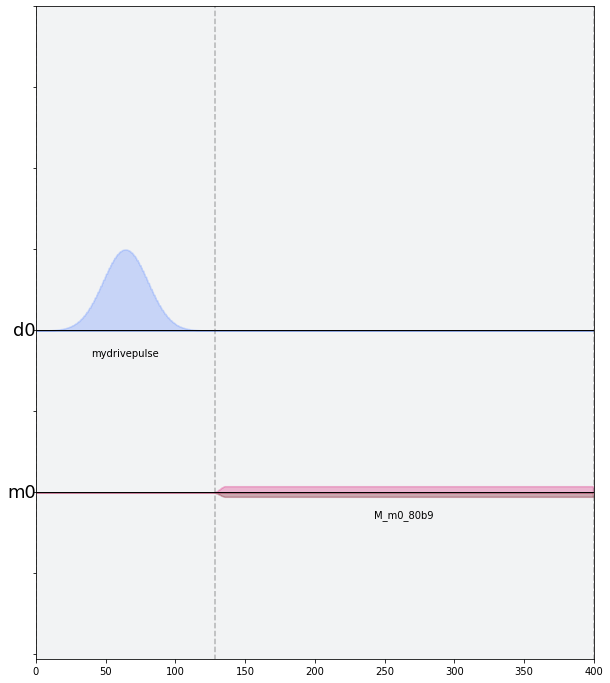

In [31]:
schedules[-1].draw(plot_range=[0,400],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [22]:
num_shots_per_frequency =4096
rabi_sweep                       = assemble(schedules,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency)


job = backend.run(ground_resonator_freq_sweep)
print (job.job_id())

5e31bf1730629b0011ab3e16


In [26]:
qubit_spec_codes = ["5e31bf1730629b0011ab3e16"] #codes for johannesburg backend
job = backend.retrieve_job("5e31bf1730629b0011ab3e16")
qubit=0
rabi_result = job.result()
rabi_data = np.ones(len(powers), dtype=np.complex_)
for i in range(len(powers)):
    rabi_data[i] = rabi_result.get_memory(i)[qubit]

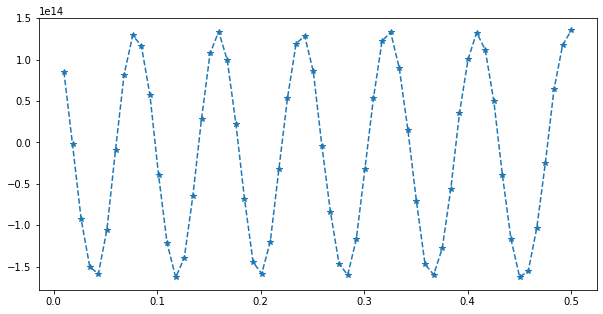

In [29]:
plt.figure(figsize=(10,5))
plt.plot(powers,rabi_data,"*--")
plt.show()

In [32]:
# auto-phase the output measurement signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)
    mvec = [np.mean(r_signal), np.mean(i_signal)]
    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)
    dvec = v_mat[0, 0:2]
    if dvec.dot(mvec) < 0:
        dvec = -dvec
    return src_mat.dot(dvec)

In [35]:
from scipy.optimize import curve_fit

0.018188839633449208


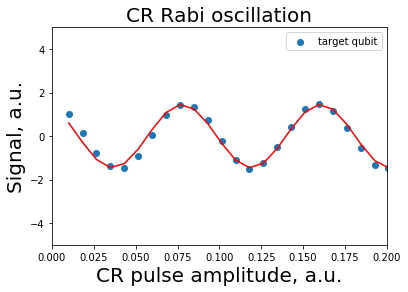

In [47]:
scale_factor = 1e-14
rabi_amp_data = get_amplitude(rabi_data)*scale_factor

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
#Fit the data
fitparams, conv = curve_fit(fit_func, powers, rabi_amp_data, [2.0,0.0,0.08,0])
#get the pi amplitude

pi_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi
plt.plot(powers, fit_func(powers, *fitparams), color='red')
plt.scatter(powers, rabi_amp_data, label='target qubit')
plt.xlim(0, 0.2)
plt.ylim(-5, 5)
plt.legend()
plt.xlabel('CR pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('CR Rabi oscillation', fontsize=20)
print(pi_amp)

# Trying increasing drive powers

In [55]:
# drive pulse parameters
drive_power = 0.4
drive_samples = 128
drive_sigma = 16
powers_lin = [pi_amp,pi_amp*3,pi_amp*5,pi_amp*7,pi_amp*9,pi_amp*11,pi_amp*13,pi_amp*15,pi_amp*17,pi_amp*19,pi_amp*21,pi_amp*23,pi_amp*25,pi_amp*27,pi_amp*29,pi_amp*31,pi_amp*33,pi_amp*35,pi_amp*37,pi_amp*39,pi_amp*41,pi_amp*43]
# creating drive pulse
schedules = []
for ii,drive_power in enumerate(powers_lin):
    schedule = pulse.Schedule(name='Qubit Rabi')
    drive_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power,
                                     sigma=drive_sigma, name='mydrivepulse')
    drive_pulse_qubit = drive_pulse(drive_chan)

    schedule += drive_pulse_qubit
    schedule += measure_gate << schedule.duration
    schedules.append(schedule)

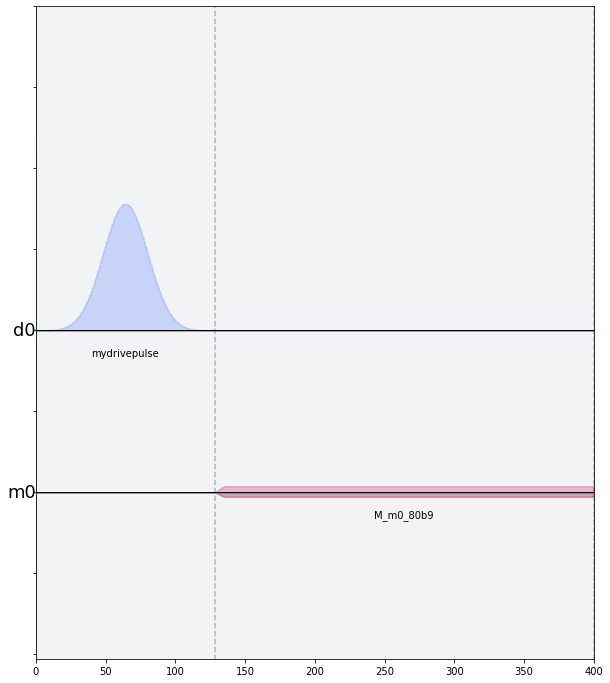

In [56]:
schedules[-1].draw(plot_range=[0,400],channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [51]:
num_shots_per_frequency =4096
rabi_sweep                       = assemble(schedules,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency)


job = backend.run(ground_resonator_freq_sweep)
print (job.job_id())

5e31c52c7eba0a00115e1ca0


In [ ]:
job = backend.retrieve_job("5e31c52c7eba0a00115e1ca0")
qubit=0
rabi_result = job.result()
rabi_linear_data = np.ones(len(powers), dtype=np.complex_)
for i in range(len(powers)):
    rabi_linear_data[i] = rabi_result.get_memory(i)[qubit]

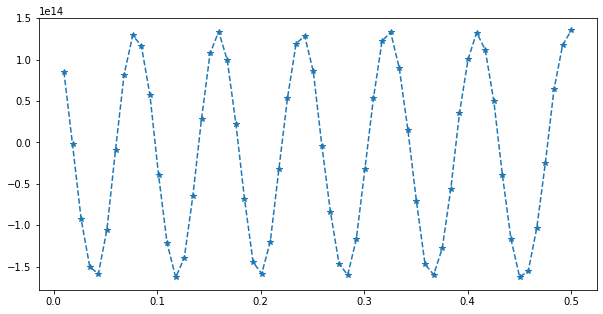

In [54]:
plt.figure(figsize=(10,5))
plt.plot(powers,rabi_data,"*--")
plt.plot(powers_lin,rabi_linear_data,".")
plt.show()